# Data Preprocessing

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

years = ["2018", "2019", "2020", "2021", "2022", "2023"]
dataframes_per_year = {}
# Match locations to transcation csv based on pole id

df_parkingLocations = pd.read_csv('/Users/anshuldevnani/Documents/school/ECE143/project/treas_parking_meters_loc_datasd.csv', usecols=["zone","pole","lat","lng", "area", "config_name"])
df_parkingLocations = df_parkingLocations.rename(columns={"pole": "pole_id"})
# remove sunday mode lines
df_parkingLocations = df_parkingLocations [ df_parkingLocations['config_name'] != "Sunday Mode" ]

## start for each year

for year in years:
    year_raw_data = pd.read_csv(f"/Users/anshuldevnani/Desktop/treas_meters_{year}_pole_by_month_datasd.csv")

    merge_2023 = pd.merge(year_raw_data, df_parkingLocations, on='pole_id', how='left')
    area_mapping = {"Core" : "Core - Columbia", "Columbia" : "Core - Columbia"}
    merge_2023['area'] = merge_2023['area'].replace(area_mapping)

    merge_2023['sum_trans_amt'] = pd.to_numeric(merge_2023['sum_trans_amt'])
    merge_2023['num_trans'] = pd.to_numeric(merge_2023['num_trans'])

    # Group by pole_id and area, then aggregate the sum of transaction amounts and the sum of transaction counts
    result_df = merge_2023.groupby(['pole_id', 'area']).agg({
        'sum_trans_amt': 'sum',
        'num_trans': 'sum'
    }).reset_index()

    result_df.columns = ['pole_id', 'area', 'total_sum_trans_amt', 'total_num_trans']


    total_poles = result_df['pole_id'].nunique()
    poles_per_area = result_df.groupby('area')['pole_id'].nunique().reset_index()
    poles_per_area.columns = ['area', 'num_poles']
    poles_per_area['percentage_of_poles'] = (poles_per_area['num_poles'] / total_poles) * 100
    poles_per_area = poles_per_area.sort_values(by='percentage_of_poles', ascending=False)



    # Group by area and aggregate the sum of transaction amounts
    total_sum_trans_area = result_df.groupby('area')['total_sum_trans_amt'].sum().reset_index()
    total_sum_trans_area.columns = ['area', 'total_sum_trans_amt_area']
    if(year == "2018" or year == "2019"):
        total_sum_trans_area['total_sum_trans_amt_area']
    else:  
        total_sum_trans_area['total_sum_trans_amt_area'] /= 100

    total_sum_trans_area = total_sum_trans_area.sort_values(by='total_sum_trans_amt_area', ascending=False)

    total_sum_area_df = pd.merge(total_sum_trans_area, poles_per_area, on='area')




    total_num_trans_area = result_df.groupby('area')['total_num_trans'].sum().reset_index()
    total_num_trans_area.columns = ['area', 'total_num_trans']


    total_num_trans_area = total_num_trans_area.sort_values(by='total_num_trans', ascending=False)

    total_sum_area_num_df = pd.merge(total_num_trans_area, total_sum_area_df, on='area')


    total_row = total_sum_area_num_df.sum(numeric_only=True)
    total_row['area'] = 'Total'

    final_df = pd.concat([total_sum_area_num_df, total_row.to_frame().T], ignore_index=True)
    # average per pole
    final_df["average per pole"] = final_df["total_sum_trans_amt_area"] / final_df["num_poles"]
    dataframes_per_year[year] = final_df



## Find the average revneue per pole in each area and compare with percentage of total poles

In [62]:
df = dataframes_per_year["2023"]

df_filtered = df[df['area'] != 'Total']

# Calculate the average revenue per pole
df_filtered['average_per_pole'] = df_filtered['total_sum_trans_amt_area'] / df_filtered['num_poles']

# Sort the DataFrame based on the average revenue per pole
df_sorted = df_filtered.sort_values(by='average_per_pole', ascending=False)

# Print the formatted table
print("{:<20} {:<20} {:<20}".format('Area', 'Average per Pole', 'Percentage of Total Poles'))
print("=" * 60)
for index, row in df_sorted.iterrows():
    print("{:<20} {:<20.2f} {:<20.2f}".format(row['area'], row['average_per_pole'], row['percentage_of_poles']))

Area                 Average per Pole     Percentage of Total Poles
Marina               5138.89              5.89                
Little Italy         3364.86              7.29                
Hillcrest            2143.88              14.20               
Core - Columbia      2035.68              10.55               
College              2003.91              0.14                
Gaslamp              1994.50              6.20                
East Village         1965.79              22.70               
Mission Hills        1498.14              3.07                
Bankers Hill         1417.46              13.24               
Five Points          1393.33              1.92                
North Park           1286.44              2.17                
University Heights   1223.46              2.66                
Cortez Hill          1142.80              7.51                
Point Loma           930.86               0.16                
Golden Hill          837.94               0.33    

/var/folders/_t/31gvrkl512x4851_fyrtx3nm0000gn/T/ipykernel_26857/3985477707.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['average_per_pole'] = df_filtered['total_sum_trans_amt_area'] / df_filtered['num_poles']


# Yearly Stats

In [63]:
# Assuming dataframes_per_year is a dictionary containing DataFrames for each year
# Replace 'dataframes_per_year' with your actual dictionary name if it's different

# Print the header boundary
print("="*60)

# Print the header
print(f"{'Year':<10}{'Total Revenue':<20}{'Total Poles Used':<20}{'Total Transactions':<20}")

# Print the data boundary
print("-"*60)

# Iterate over years and print the data
for year, df in dataframes_per_year.items():
    total_revenue = df.loc[df['area'] == 'Total', 'total_sum_trans_amt_area'].item()
    total_poles = df.loc[df['area'] == 'Total', 'num_poles'].item()
    total_trans = df.loc[df['area'] == 'Total', 'total_num_trans'].item()

    formatted_revenue = "${:,.2f}".format(total_revenue)
    formatted_poles = "{:,}".format(total_poles)
    formatted_trans = "{:,}".format(total_trans)

    print(f"{year:<10}{formatted_revenue:<20}{formatted_poles:<20}{formatted_trans:<20}")

# Print the data boundary
print("="*60)

    

Year      Total Revenue       Total Poles Used    Total Transactions  
------------------------------------------------------------
2018      $11,293,715.35      4,824.0             10,670,383.0        
2019      $11,877,929.38      4,825.0             10,597,096.0        
2020      $2,447,509.33       4,585.0             2,000,710.0         
2021      $7,365,438.01       4,246.0             5,438,788.0         
2022      $8,229,361.71       3,840.0             5,651,651.0         
2023      $7,513,495.91       3,648.0             5,059,835.0         


# Plot revneue per area per year 

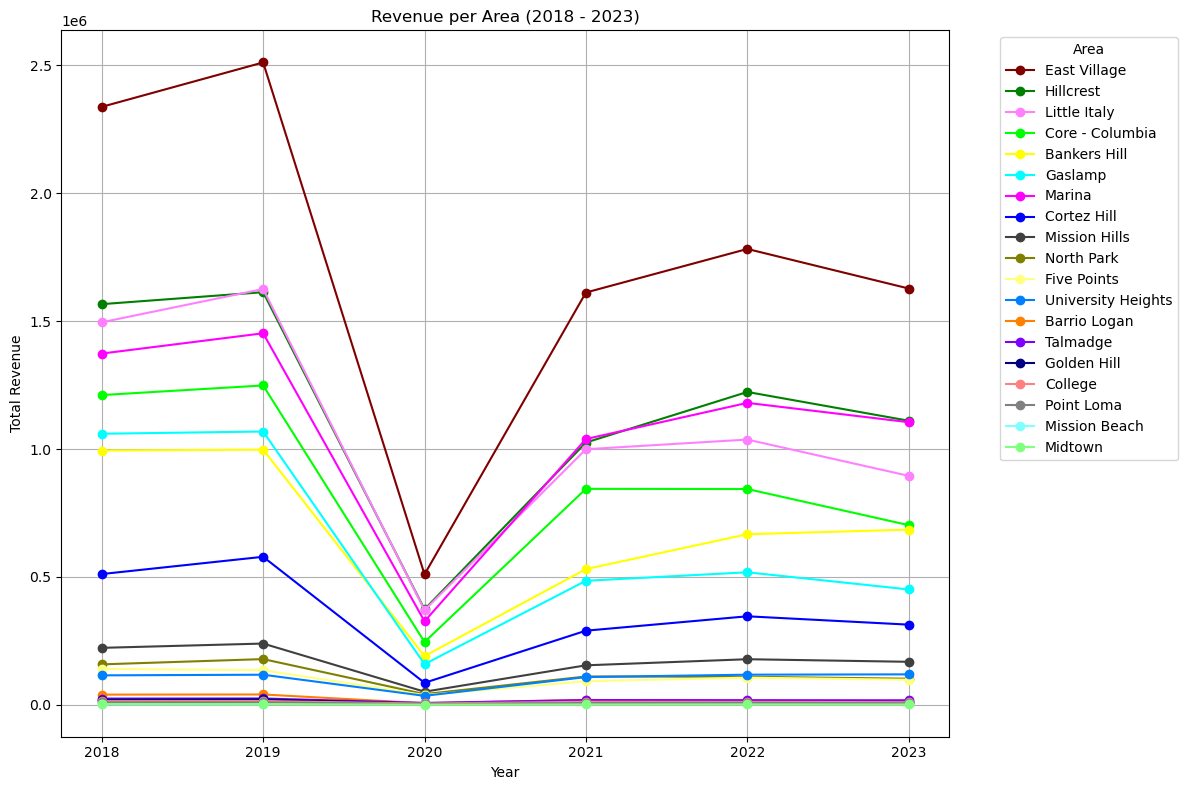

In [64]:
# Color mapping dictionary
color_mapping = {
    'Core': (255, 0, 0),              # Red
    'Core - Columbia': (0, 255, 0),    # Green
    'Cortez Hill': (0, 0, 255),        # Blue
    'Bankers Hill': (255, 255, 0),     # Yellow
    'Marina': (255, 0, 255),           # Magenta
    'Gaslamp': (0, 255, 255),          # Cyan
    'East Village': (128, 0, 0),       # Maroon
    'Hillcrest': (0, 128, 0),          # Green (dark)
    'Golden Hill': (0, 0, 128),        # Navy
    'North Park': (128, 128, 0),       # Olive
    'Cortez': (192, 192, 192),         # Silver
    'Point Loma': (128, 128, 128),     # Gray
    'Mission Hills': (64, 64, 64),     # Dark Gray
    'Barrio Logan': (255, 128, 0),     # Orange
    'Columbia': (255, 0, 128),         # Pink
    'Little Italy': (255, 128, 255),
    'University Heights': (0, 128, 255),# Light Blue
    'Talmadge': (128, 0, 255),         # Purple (light)
    'Midtown': (128, 255, 128),        # Mint
    'College': (255, 128, 128),        # Salmon
    'Five Points': (255, 255, 128),    # Banana
    'Mission Beach': (128, 255, 255)   # Sky Blue
}

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Iterate through each area and plot a line connecting revenue across years
for area, revenue_dict in line_plot_dict['2018'].items():
    if area == 'Total':
        continue
    
    # Initialize lists to store years and revenues for the current area
    years = []
    revenues = []

    # Iterate through each year and add the revenue for the current area
    for year in sorted(line_plot_dict.keys()):
        if area not in line_plot_dict[year]:
            continue
        years.append(int(year))
        revenues.append(line_plot_dict[year][area])

    # Get the RGB color for the current area from the color mapping dictionary
    color = [component / 255 for component in color_mapping[area]]

    # Plot the line connecting revenue across years for the current area
    plt.plot(years, revenues, marker='o', label=area, color=color)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Revenue per Area (2018 - 2023)')

# Show legend
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()